# Aproximating images with transparent triangles

As my objective function I chose a problem I've seen some time ago when I was playing with genetic algortihms for the first time ([original link](https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/)). The function is as follows: Given an image `i` and `n`, approximate `i` with `n` transparent triangles such that the byte difference is minimal. Triangle is a 10D vector of 3 pairs of coordinates and a color 4-tuple represetning the RGBA coloring.

### Optimal solution
It is not an easy task to find an optimal solution to an arbitrary input picture, as you don't know whether the number of triangles is sufficient to represent the input picture. I prepared two suites to analyze:
1. manually constructed picture with the number of triangles known
2. funtime approximating my face

## Prep notebook

In [1]:
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', '..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
from image import TriangleDraw, TriangleMutation, TriangleCrossover
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from IPython.display import display

def disp(image: Image, width: int = 400):
    factor = width/image.width
    h = int(image.height * factor)
    image = image.resize((width,h), Image.ANTIALIAS)
    display(image)

In [4]:
from datetime import datetime
print("start", datetime.now())

start 2020-06-06 17:59:54.948742


### Testing suite

In [5]:
test_base_im = Image.new("RGB", (100,100))
test_im_generator = TriangleDraw(test_base_im, 1)

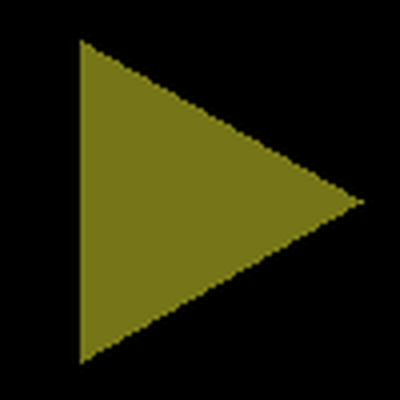

In [6]:
tst1_v = np.array([90,  50,  20,  90,  20,  10,  150, 150,  30, 200])
test1_1_im = test_im_generator.interpret(tst1_v)
test_1_1 = TriangleDraw(test1_1_im, 1)
disp(test1_1_im)

In [7]:
test_base_im = Image.new("RGB", (100,100))
test_im_generator4 = TriangleDraw(test_base_im, 4)

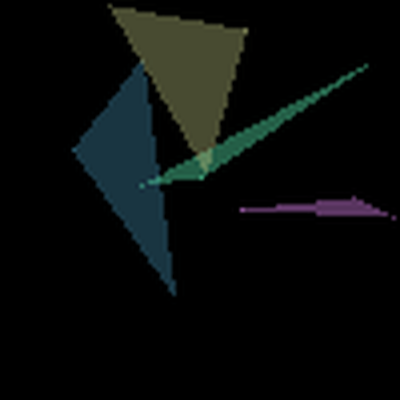

In [8]:
tst4_v = np.array([ 43,  73,  35,  15,  18,  37,  35,  46,  50,  44,
                    91,  16,  60,  52,  88,  49,  98,  54,  61,   7,
                    51,  42,  27,   1,  63, 136, 165, 100,  97, 255,
                   191,  95, 228, 136, 246,  99, 192, 198, 131,  96])
test1_4_im = test_im_generator4.interpret(tst4_v)
test_1_4 = TriangleDraw(test1_4_im, 4)
disp(test1_4_im)

## Example

[Ax Ay Bx By Cx Cy]
[89 46 28 89 26 12]
( R,  G,  B,  A)
(63, 133, 61, 104)


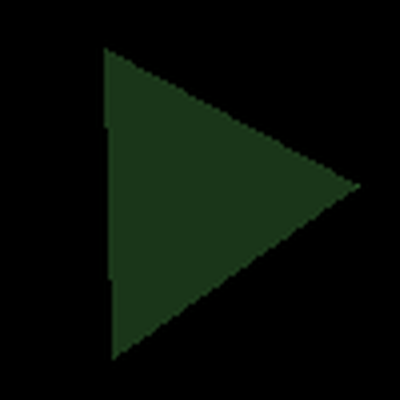

In [9]:
im = Image.new("RGB", (100,100))
td = TriangleDraw(im, 1)
p = td.generate_point()
print("[Ax Ay Bx By Cx Cy]", str(p[:6]), sep="\n")
print("( R,  G,  B,  A)", str(tuple(p[6:])), sep="\n")
disp(td.interpret(p))

## Shoot and Go

First we will be trying to use Shoot and go heuristics. For this we use the neighborhood `d` as maximum difference of `d` in one dimension. This can be interpretted as moving a single point of a triangle in either direction by max of `d` pixels or changing one color (r,g or b) by max `d` shades.

In [10]:
from heur_sg import ShootAndGo

def experiment(of, maxeval, num_runs, hmax, random_descent):
    method = 'RD' if random_descent else 'SD'
    results = []
    for i in tqdm(range(num_runs), 'Testing method={}, hmax={}'.format(method, hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, random_descent=random_descent).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}_{}'.format(method, hmax) # name of the heuristic
        result['method'] = method
        result['hmax'] = hmax
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'method', 'hmax', 'best_x', 'best_y', 'neval'])

In [11]:
NUM_RUNS = 10 #TODO change back
MAX_EVAL_1 = 4000
MAX_EVAL_4 = 16000
hmaxes = [0,1,5,20,np.inf]
table = pd.DataFrame()

In [12]:
for hmax in hmaxes:
    res = experiment(of=test_1_1, maxeval=MAX_EVAL_1, num_runs=NUM_RUNS, hmax=hmax, random_descent=False)
    res['of'] = 'test_1'
    res['smol'] = 'smol'
    table = pd.concat([table, res], axis=0)

for hmax in hmaxes:
    res = experiment(of=test_1_1, maxeval=MAX_EVAL_1, num_runs=NUM_RUNS, hmax=hmax, random_descent=True)
    res['of'] = 'test_1'
    res['smol'] = 'smol'
    table = pd.concat([table, res], axis=0)

for hmax in hmaxes:
    res = experiment(of=test_1_1, maxeval=MAX_EVAL_1*10, num_runs=NUM_RUNS, hmax=hmax, random_descent=False)
    res['of'] = 'test_1'
    res['smol'] = 'big'
    table = pd.concat([table, res], axis=0)

for hmax in hmaxes:
    res = experiment(of=test_1_1, maxeval=MAX_EVAL_1*10, num_runs=NUM_RUNS, hmax=hmax, random_descent=True)
    res['of'] = 'test_1'
    res['smol'] = 'big'
    table = pd.concat([table, res], axis=0)

In [13]:
for hmax in hmaxes:
    res = experiment(of=test_1_4, maxeval=MAX_EVAL_4, num_runs=NUM_RUNS, hmax=hmax, random_descent=False)
    res['of'] = 'test_4'
    res['smol'] = 'smol'
    table = pd.concat([table, res], axis=0)

for hmax in hmaxes:
    res = experiment(of=test_1_4, maxeval=MAX_EVAL_4, num_runs=NUM_RUNS, hmax=hmax, random_descent=True)
    res['of'] = 'test_4'
    res['smol'] = 'smol'
    table = pd.concat([table, res], axis=0)

for hmax in hmaxes:
    res = experiment(of=test_1_4, maxeval=MAX_EVAL_4*10, num_runs=NUM_RUNS, hmax=hmax, random_descent=False)
    res['of'] = 'test_4'
    res['smol'] = 'big'
    table = pd.concat([table, res], axis=0)

for hmax in hmaxes:
    res = experiment(of=test_1_4, maxeval=MAX_EVAL_4*10, num_runs=NUM_RUNS, hmax=hmax, random_descent=True)
    res['of'] = 'test_4'
    res['smol'] = 'big'
    table = pd.concat([table, res], axis=0)

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


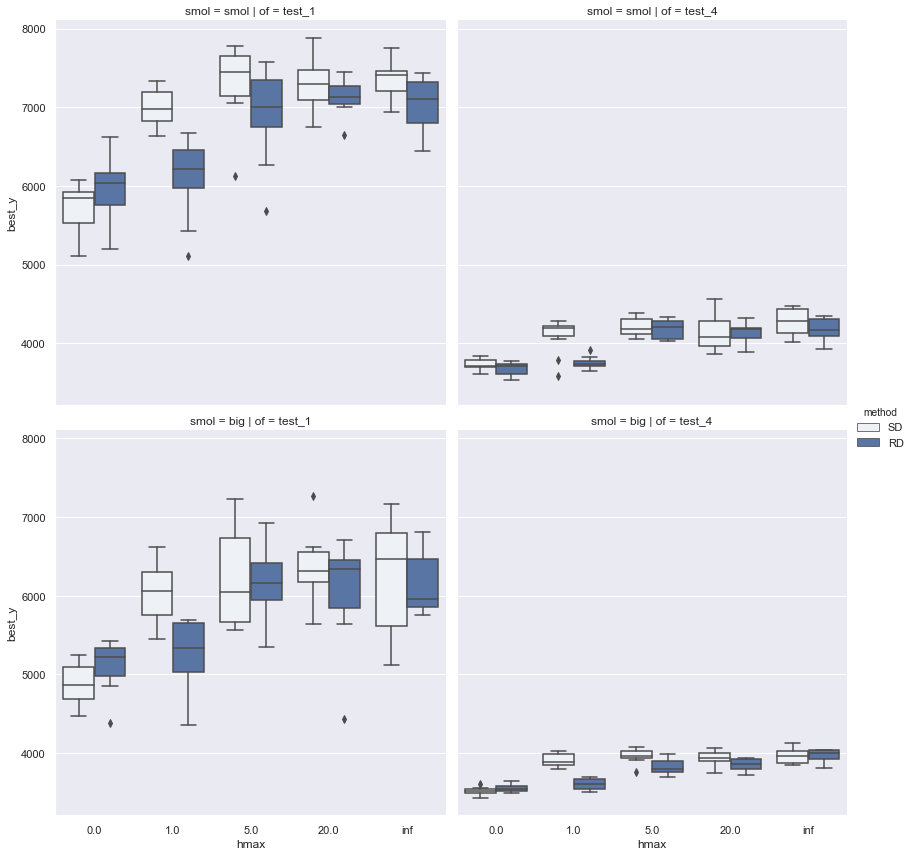

In [14]:
g = sns.FacetGrid(table, col='of', row='smol', height=6)
ax = g.map(sns.boxplot, 'hmax', 'best_y', 'method').add_legend(title='method')

We can see that for one triangle the number of evaluations improves the result, but for four triangles the result doesn't improve as much. Additionally we can see random search performing the best which might be due to the number of evaluations being too small such that it is better invested into searching other part of the search space instead fine tuning one solution.

### Example result visualisation

In [15]:
def show_example(r1,r2,of):
    print(r1["best_y"], r2["best_y"])
    disp(of.im)
    disp(of.interpret(r1["best_x"]))
    disp(of.interpret(r2["best_x"]))

In [16]:
ex1_smol = ShootAndGo(test_1_1, maxeval=MAX_EVAL_1, hmax=0).search()
ex1_big = ShootAndGo(test_1_1, maxeval=MAX_EVAL_1 * 10, hmax=0).search()

6421.228387154595 4990.322133890757


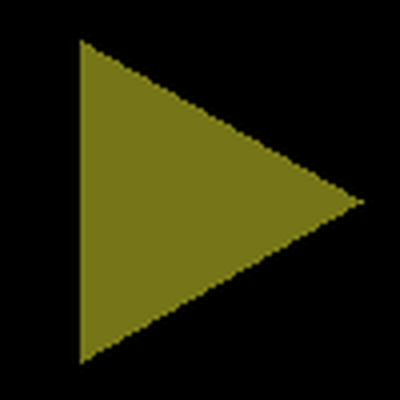

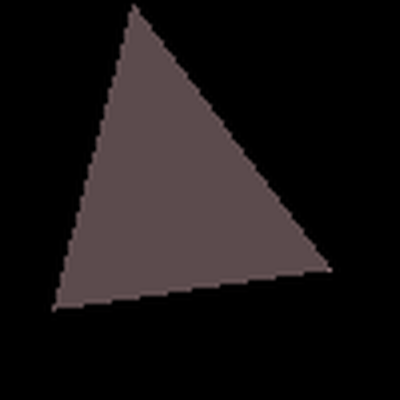

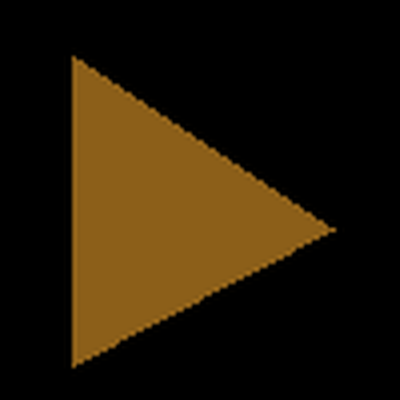

In [17]:
show_example(ex1_smol, ex1_big,test_1_1)

Noticable thing is that the solution for less evaluations gets roughly the shape and some color as the problem is slightly skewed by having large black area. This is even more visible in the 4 triangles which contain in proportion evne more black space.

In [18]:
ex4_smol = ShootAndGo(test_1_4, maxeval=MAX_EVAL_4, hmax=0).search()
ex4_big = ShootAndGo(test_1_4, maxeval=MAX_EVAL_4 * 10, hmax=0).search()

3572.1800066625983 3569.8668042379395


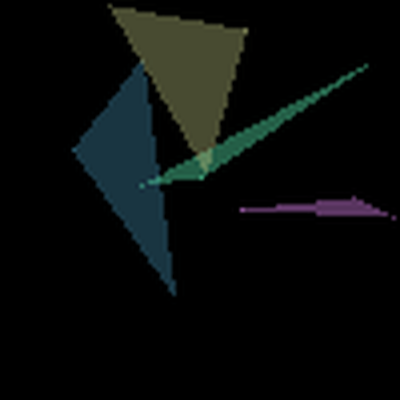

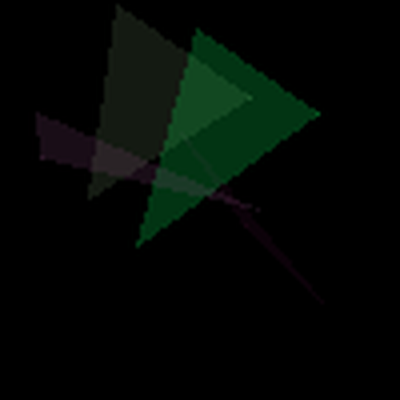

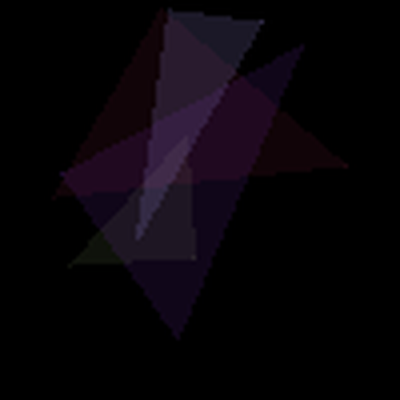

In [19]:
show_example(ex4_smol, ex4_big, test_1_4)

In [20]:
print("checkpoint", datetime.now())

checkpoint 2020-06-06 18:50:20.904525


## GO

For Genetic optimization, among using generic heuristics, I implemented a triangle mutation which swaps a single triangle for a randomly generated one. A triangle crossover respects the triangle nature of the vector and picks whole triangles from parents instead of randomly mixing points and colors.

In [21]:
from heur_go import GeneticOptimization, UniformMultipoint, Crossover, RandomCombination
from heur_aux import CauchyMutation, MirrorCorrection

In [22]:
def experiment_go(of, maxeval, num_runs, N, M, Tsel1, Tsel2, mutation, crossover):
    results = []
    heur_name = 'GO_{}'.format(N)
    for i in tqdm(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N, M=M, Tsel1=Tsel1, Tsel2=Tsel2, 
                                     mutation=mutation, crossover=crossover).search()
        result['run'] = i
        result['heur'] = heur_name
        result['N'] = N
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'N', 'best_x', 'best_y', 'neval'])

In [23]:
mutations = {
    "cauchy": CauchyMutation(r=0.75, correction=MirrorCorrection(test_1_4)),
    "triangle": TriangleMutation(test_1_4)
}
crossovers = {
    'crossover': Crossover(),
    'uniform_1': UniformMultipoint(1),
    'uniform_3': UniformMultipoint(3),
    'combination': RandomCombination(),
    'triangle': TriangleCrossover(test_1_4)
}

In [25]:
table_go = pd.DataFrame()
for mutname, mutation in mutations.items():
    for crossname, cross in crossovers.items():
        print(mutname, crossname)
        for N in [1, 2, 5, 10, 25, 100]:
            res = experiment_go(of=test_1_4, maxeval=MAX_EVAL_4, num_runs=NUM_RUNS, N=N, M=N*3, Tsel1=1, Tsel2=.1, 
                                mutation=mutation, crossover=cross)
            res["mutation"] = mutname
            res["crossover"] = crossname
            table_go = pd.concat([table_go, res], axis=0)

cauchy crossover



cauchy uniform_1



cauchy uniform_3



cauchy combination



cauchy triangle



triangle crossover



triangle uniform_1



triangle uniform_3



triangle combination



triangle triangle


/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


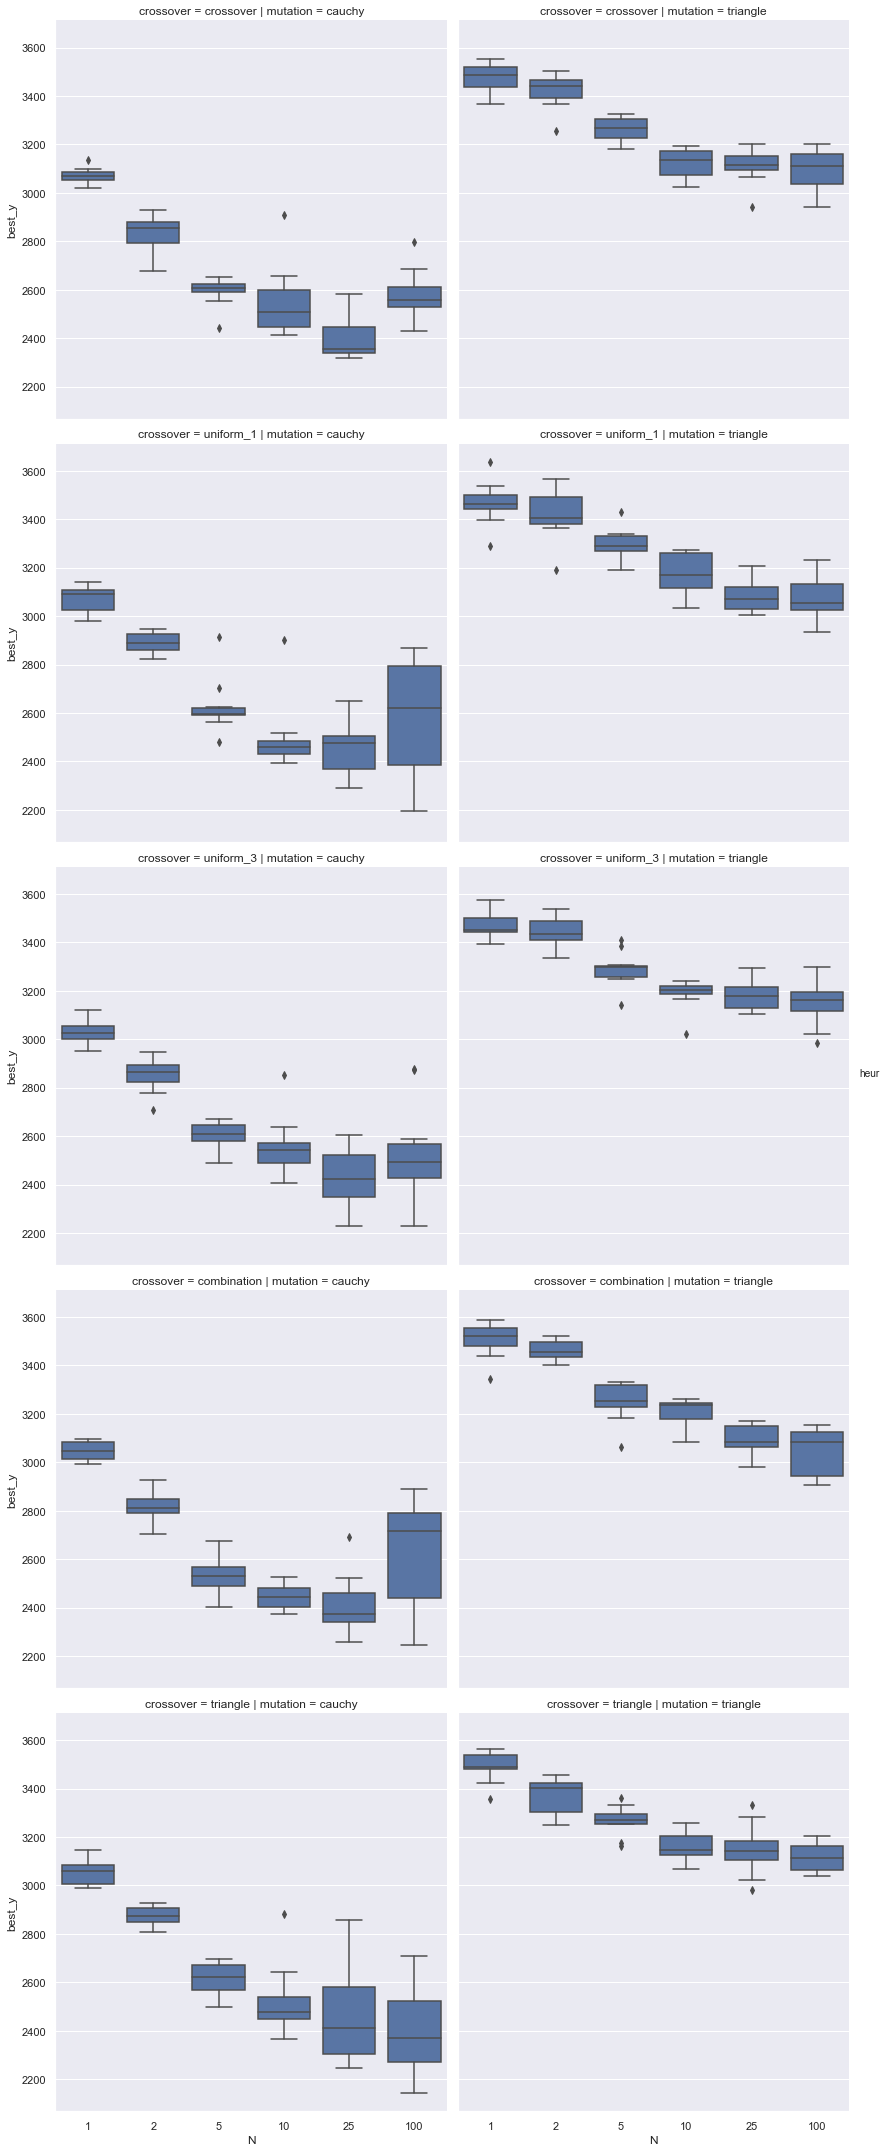

In [26]:
g = sns.FacetGrid(table_go, col='mutation', row="crossover", height=6)
ax = g.map(sns.boxplot, 'N', 'best_y').add_legend(title='heur')

Unfortunately we can see that generic mutations and crossovers are performing better than these domain specific.

### Example result visualisation

In [27]:
go_ex = GeneticOptimization(test_1_4, MAX_EVAL_4, N=5, M=15, Tsel1=1, Tsel2=.1, 
                    mutation=CauchyMutation(r=0.75, correction=MirrorCorrection(test_1_4)),
                    crossover=RandomCombination()).search()

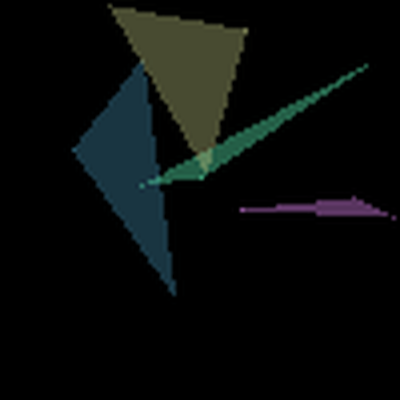

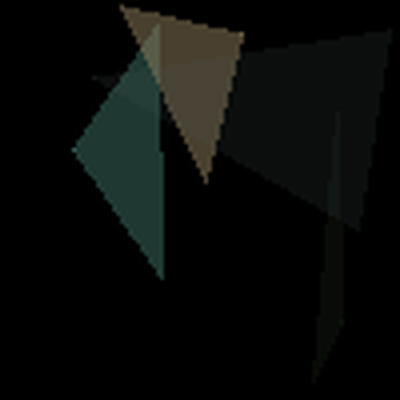

In [28]:
disp(test_1_4.im)
disp(test_1_4.interpret(go_ex["best_x"]))

In [29]:
print("end", datetime.now())

end 2020-06-06 22:37:34.029556


## Me

In [ ]:
from logging_go import LoggingGeneticOptimization

In [64]:
def get_go(of, evals):
    return LoggingGeneticOptimization(of, evals, N=25, M=75, Tsel1=1, Tsel2=.1, 
                    mutation=CauchyMutation(r=0.75, correction=MirrorCorrection(of)),
                    crossover=RandomCombination()).search()

In [75]:
me_img = Image.open("me.jpg")
me_10 = TriangleDraw(me_img, 10)
me_40 = TriangleDraw(me_img, 40)

In [77]:
print("start", datetime.now())
me_smol = get_go(me_10, MAX_EVAL_4 * 25)

start 2020-06-07 21:32:23.633198


In [78]:
print("start", datetime.now())
me_big = get_go(me_40, MAX_EVAL_4 * 100)

start 2020-06-07 23:25:35.207239


In [79]:
print("end", datetime.now())

end 2020-06-08 12:40:55.212859


In [85]:
import pickle
with open('me_smol.pickle', 'wb') as handle:
    pickle.dump(me_smol, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('me_big.pickle', 'wb') as handle:
    pickle.dump(me_big, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
me_smol["log_data"]

,neval,y,x
0,19075,68503.855643,"[0, 21, 394, 980, 669, 570, 466, 214, 615, 100..."
1,38125,65335.166036,"[31, 76, 373, 1010, 649, 528, 633, 125, 508, 9..."
2,57175,62608.896037,"[13, 34, 347, 976, 556, 555, 626, 348, 398, 10..."
3,76225,62365.229728,"[14, 43, 12, 879, 481, 462, 614, 494, 369, 990..."
4,95275,60321.645609,"[8, 6, 30, 689, 445, 561, 552, 580, 357, 1020,..."
5,114325,60321.645609,"[8, 6, 30, 689, 445, 561, 552, 580, 357, 1020,..."
6,133375,60321.645609,"[8, 6, 30, 689, 445, 561, 552, 580, 357, 1020,..."
7,152425,60321.645609,"[8, 6, 30, 689, 445, 561, 552, 580, 357, 1020,..."
8,171475,60321.645609,"[8, 6, 30, 689, 445, 561, 552, 580, 357, 1020,..."
9,190525,60321.645609,"[8, 6, 30, 689, 445, 561, 552, 580, 357, 1020,..."


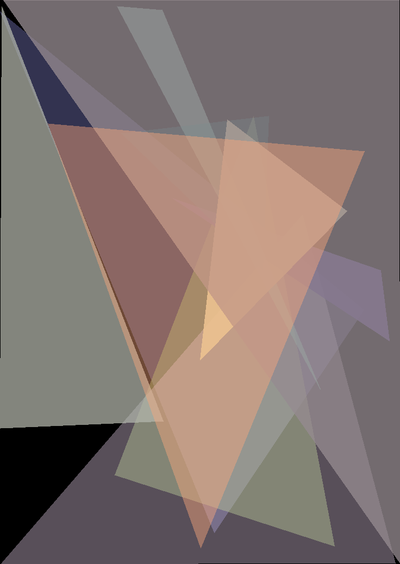

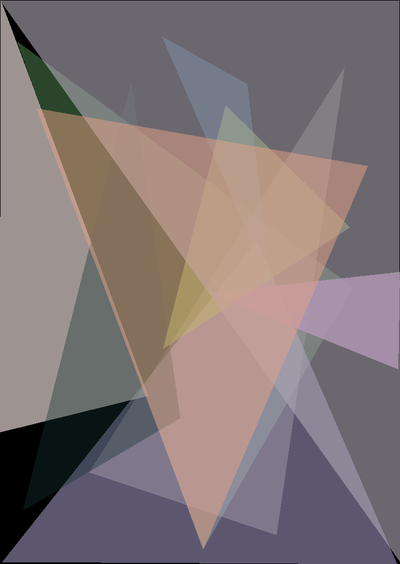

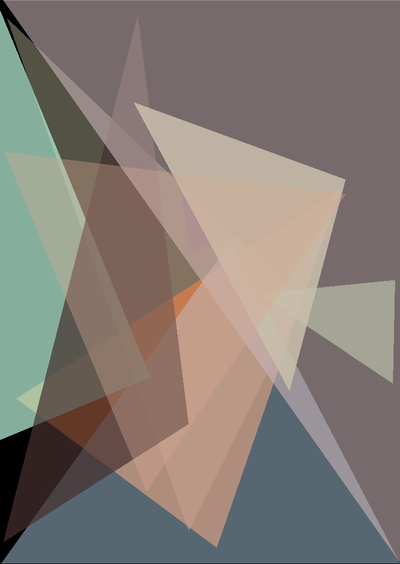

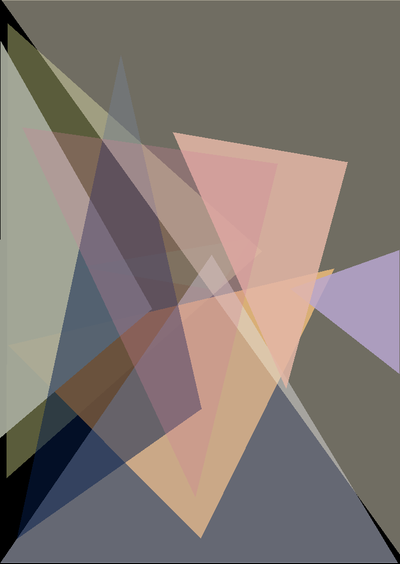

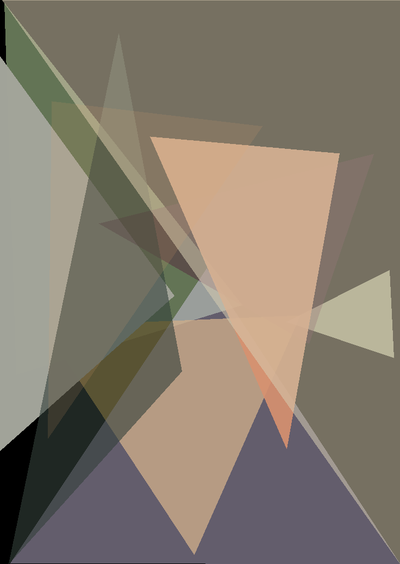

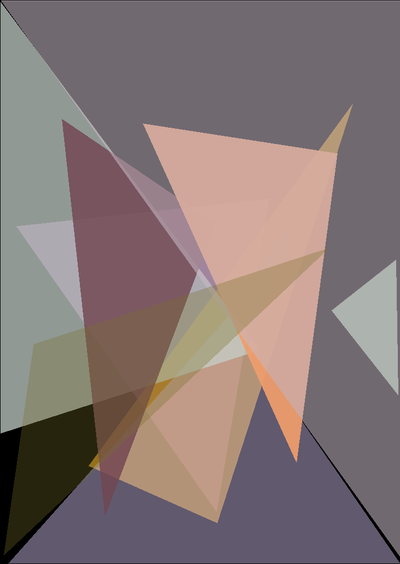

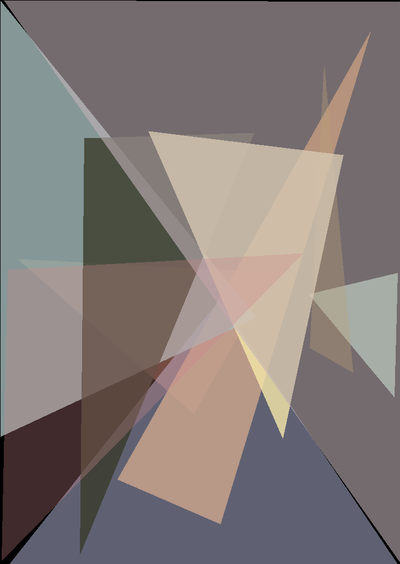

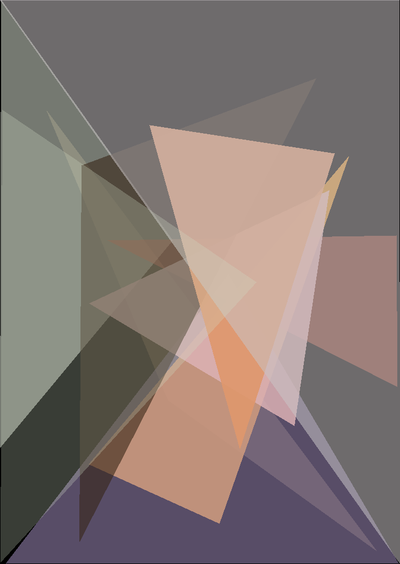

In [94]:
for x in me_smol["log_data"].drop_duplicates(subset=['y'], keep='first').x:
    disp(me_10.interpret(x))

In [96]:
me_big["log_data"]

,neval,y,x
0,76225,61163.734925,"[505, 771, 317, 327, 242, 811, 214, 908, 408, ..."
1,152425,59941.520902,"[648, 758, 32, 105, 145, 804, 431, 917, 258, 9..."
2,228625,59736.488949,"[446, 868, 479, 573, 297, 315, 346, 1008, 478,..."
3,304825,59736.488949,"[446, 868, 479, 573, 297, 315, 346, 1008, 478,..."
4,381025,59736.488949,"[446, 868, 479, 573, 297, 315, 346, 1008, 478,..."
5,457150,59473.200301,"[147, 64, 378, 459, 193, 253, 636, 851, 205, 4..."
6,533350,59473.200301,"[147, 64, 378, 459, 193, 253, 636, 851, 205, 4..."
7,609550,59473.200301,"[147, 64, 378, 459, 193, 253, 636, 851, 205, 4..."
8,685750,59123.456733,"[533, 891, 668, 642, 531, 645, 656, 894, 573, ..."
9,761950,59123.456733,"[533, 891, 668, 642, 531, 645, 656, 894, 573, ..."


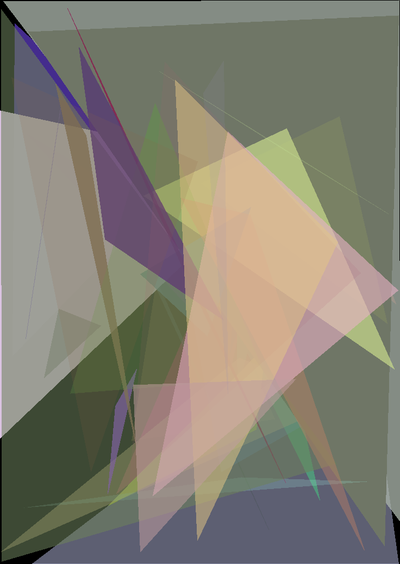

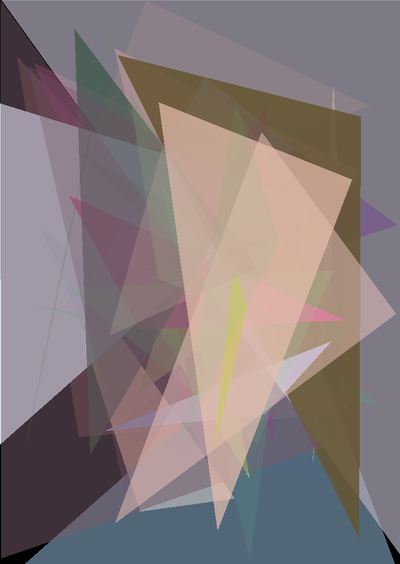

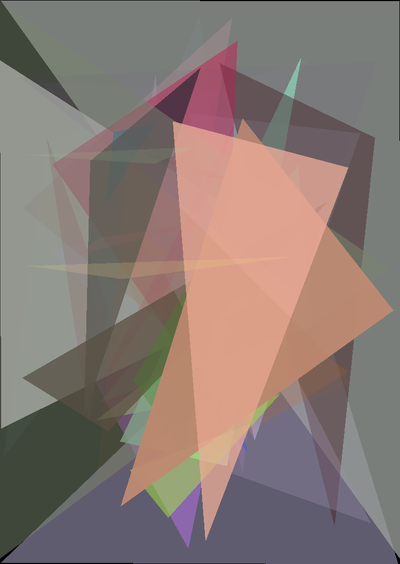

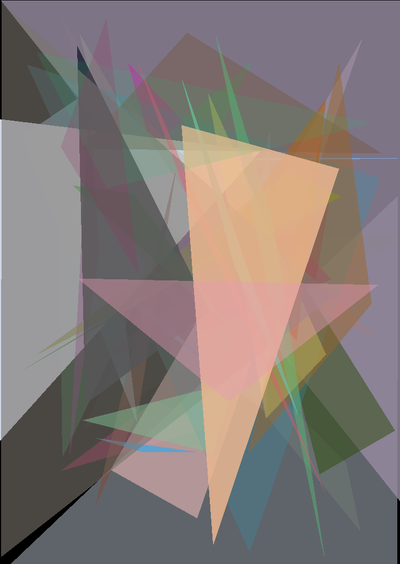

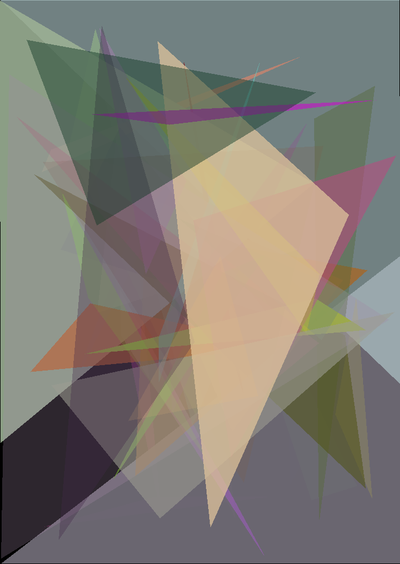

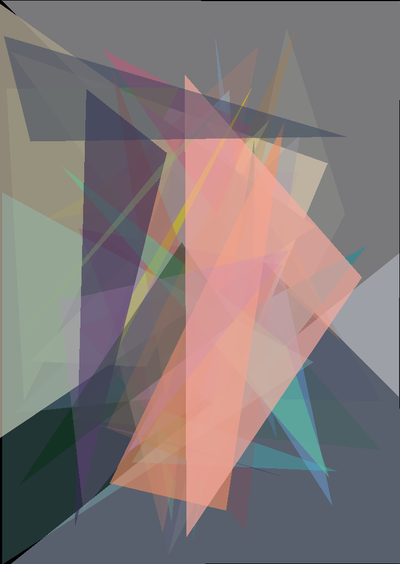

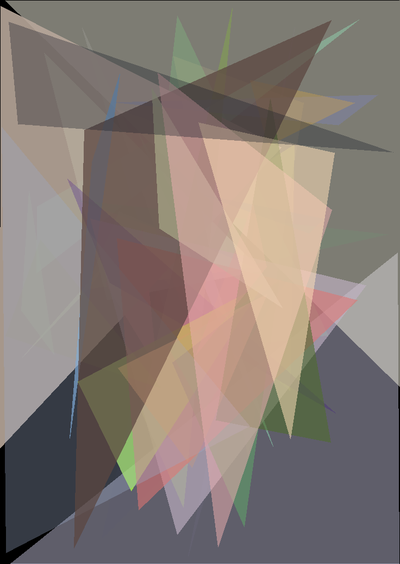

In [95]:
for x in me_big["log_data"].drop_duplicates(subset=['y'], keep='first').x:
    disp(me_40.interpret(x))

## Conclusion
- it's horrible

# Misc and wtf

In [30]:
def py_prod(x):
    p = int(1)
    for i in x:
        p *= int(i)
    return p

In [31]:
float(py_prod(test_1_1.b))

4.228250625e+21

In [32]:
float(py_prod(test_1_4.b))

3.196265793150785e+86